[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frhack/oli_ai/blob/main/notebooks/oli_ai_programmazione.ipynb)

# Riconoscimento cifre scritte a mano con Cosine Similarity


In [11]:
from keras.datasets import mnist
from matplotlib import pyplot as plt
from oli_ai.mnist_lib import *
import numpy as np

data = mnist.load_data()
(X_train, y_train), (X_test, y_test) = data
print(len(X_train))
print(len(X_test))
print(X_train[0].shape)
print(y_train[0])  
#X_train.shape


60000
10000
(28, 28)
5


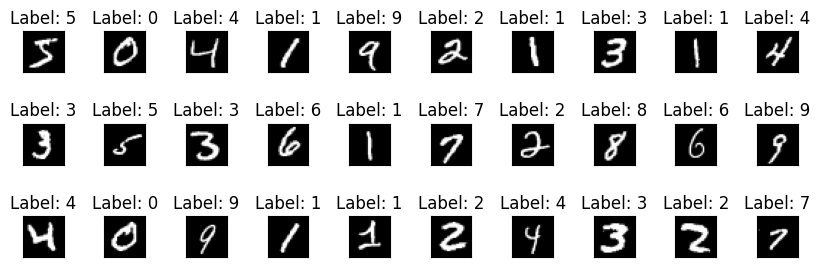

In [13]:




#first_image = X_train[0]
#first_image = np.array(first_image, dtype='float')
#plt.imshow(first_image, cmap='gray')
#plt.show()

plot_imgs_labels(X_train,y_train, 3, 10)





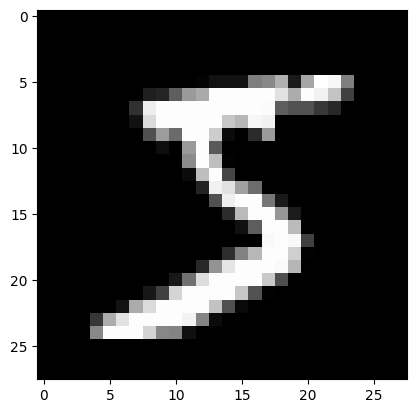

In [12]:
plot_img(X_train[0])


TypeError: Invalid shape (784,) for image data

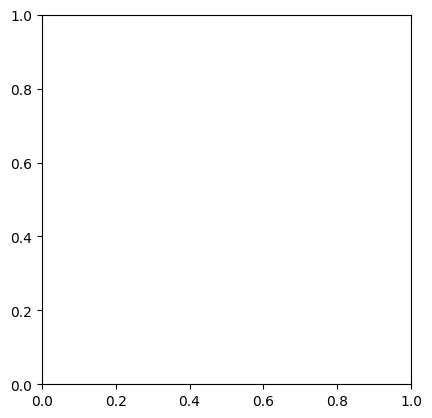

In [15]:
avgs = [np.average(X_train[y_train==i],0) for i in range(10)]
avgs = np.array(avgs)
avgs = avgs.reshape((avgs.shape[0], 28*28)).astype('float32')

plot_img(avgs[0])